In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=3

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [ ]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199329, 2) (51411, 2)
train/valid # (199329, 2) (51411, 2)
rand split across time
train has 199329 records out of 389630 records
valid has 51411 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1557
0
(199329, 1, 36) (199329, 7, 32) (199329, 1) (199329, 1)
(199329, 260) (199329,) (199329,)
(51411, 1, 36) (51411, 7, 32) (51411, 1) (51411, 1)
(51411, 260) (51411,) (51411,)
(5803, 1, 36) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 260) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38492	valid-rmse:2.42831
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.97985	valid-rmse:1.00298
[100]	train-rmse:0.571319	valid-rmse:0.593997
[150]	train-rmse:0.487229	valid-rmse:0.514526
[200]	train-rmse:0.47093	valid-rmse:0.502451
[250]	train-rmse:0.465676	valid-rmse:0.500699
[300]	train-rmse:0.461628	valid-rmse:0.500423
[350]	train-rmse:0.45838	valid-rmse:0.500388
Stopping. Best iteration:
[333]	train-rmse:0.459375	valid-rmse:0.500353

0.21102574 0.25035298
[0.25035298]
-1 mean score 0.25035298
0.190828248858


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926861  0.002249  0.196626    7  2017-04-16
472     2.507290  2.536387 -0.029097  0.204017    1  2017-04-17
473     2.661330  2.664182 -0.002852  0.224649    2  2017-04-18
474     2.754815  2.741251  0.013564  0.187938    3  2017-04-19
475     2.713762  2.711001  0.002761  0.213930    4  2017-04-20
476     2.999000  2.981282  0.017718  0.141025    5  2017-04-21
477     3.075529  3.076032 -0.000503  0.167613    6  2017-04-22

0.190828248858


pred         y     error    error2  day        date
dayidx                                                         
471     2.926861  2.929110  0.002249  0.196626    7  2017-04-16
472     2.536387  2.507290 -0.029097  0.204017    1  2017-04-17
473     2.664182  2.661330 -0.002852  0.224649    2  2017-04-18
474     2.741251  2.754815  0.013564  0.187938    3  2017-04-19
475     2.711001  2.713762  0.002761  0.213930    4  2017-04-20
476     2.981282  2.999000  0.017718  0.141025    5  2017-04-21
477     3.076032  3.075529 -0.000503  0.167613    6  2017-04-22

(829, 260)


In [ ]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199102, 2) (51355, 2)
train/valid # (199102, 2) (51355, 2)
rand split across time
train has 199102 records out of 389630 records
valid has 51355 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1555
0
(199102, 1, 36) (199102, 7, 32) (199102, 1) (199102, 1)
(199102, 260) (199102,) (199102,)
(51355, 1, 36) (51355, 7, 32) (51355, 1) (51355, 1)
(51355, 260) (51355,) (51355,)
(6632, 1, 36) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 260) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3847	valid-rmse:2.42826
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.982396	valid-rmse:1.00718
[100]	train-rmse:0.576157	valid-rmse:0.600414
[150]	train-rmse:0.493087	valid-rmse:0.521074
[200]	train-rmse:0.477166	valid-rmse:0.509085
[250]	train-rmse:0.471996	valid-rmse:0.507274
[300]	train-rmse:0.46818	valid-rmse:0.506986
Stopping. Best iteration:
[299]	train-rmse:0.468234	valid-rmse:0.506984

0.2192428 0.25703278
[0.25703278]
-1 mean score 0.25703278
0.197081699967


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914439  0.014671  0.207094    7  2017-04-16
472     2.507290  2.526355 -0.019064  0.209155    1  2017-04-17
473     2.661330  2.651637  0.009693  0.229389    2  2017-04-18
474     2.754815  2.732305  0.022510  0.194832    3  2017-04-19
475     2.713762  2.711060  0.002702  0.223802    4  2017-04-20
476     2.999000  2.986252  0.012748  0.147107    5  2017-04-21
477     3.075529  3.064660  0.010869  0.168193    6  2017-04-22

0.197081699967


pred         y     error    error2  day        date
dayidx                                                         
471     2.914439  2.929110  0.014671  0.207094    7  2017-04-16
472     2.526355  2.507290 -0.019064  0.209155    1  2017-04-17
473     2.651637  2.661330  0.009693  0.229389    2  2017-04-18
474     2.732305  2.754815  0.022510  0.194832    3  2017-04-19
475     2.711060  2.713762  0.002702  0.223802    4  2017-04-20
476     2.986252  2.999000  0.012748  0.147107    5  2017-04-21
477     3.064660  3.075529  0.010869  0.168193    6  2017-04-22

(829, 260)


3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198922, 2) (51308, 2)
train/valid # (198922, 2) (51308, 2)
rand split across time
train has 198922 records out of 389630 records
valid has 51308 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1554
0
(198922, 1, 36) (198922, 7, 32) (198922, 1) (198922, 1)
(198922, 260) (198922,) (198922,)
(51308, 1, 36) (51308, 7, 32) (51308, 1) (51308, 1)
(51308, 260) (51308,) (51308,)
(7461, 1, 36) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 260) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38446	valid-rmse:2.42817
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.983244	valid-rmse:1.00606
[100]	train-rmse:0.577944	valid-rmse:0.600354
[150]	train-rmse:0.495212	valid-rmse:0.52246
[200]	train-rmse:0.479228	valid-rmse:0.510836
[250]	train-rmse:0.474058	valid-rmse:0.509243
[300]	train-rmse:0.470112	valid-rmse:0.509078
[350]	train-rmse:0.46729	valid-rmse:0.509154
Stopping. Best iteration:
[310]	train-rmse:0.469537	valid-rmse:0.509062

0.2204648 0.25914407
[0.25914407]
-1 mean score 0.25914407
0.199683234096


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901350  0.027760  0.210038    7  2017-04-16
472     2.507290  2.528321 -0.021031  0.210125    1  2017-04-17
473     2.661330  2.642515  0.018815  0.242079    2  2017-04-18
474     2.754815  2.747198  0.007617  0.197445    3  2017-04-19
475     2.713762  2.709263  0.004498  0.221582    4  2017-04-20
476     2.999000  2.988939  0.010061  0.146109    5  2017-04-21
477     3.075529  3.065628  0.009901  0.170406    6  2017-04-22

0.199683234096


pred         y     error    error2  day        date
dayidx                                                         
471     2.901350  2.929110  0.027760  0.210038    7  2017-04-16
472     2.528321  2.507290 -0.021031  0.210125    1  2017-04-17
473     2.642515  2.661330  0.018815  0.242079    2  2017-04-18
474     2.747198  2.754815  0.007617  0.197445    3  2017-04-19
475     2.709263  2.713762  0.004498  0.221582    4  2017-04-20
476     2.988939  2.999000  0.010061  0.146109    5  2017-04-21
477     3.065628  3.075529  0.009901  0.170406    6  2017-04-22

(829, 260)


4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198759, 2) (51269, 2)
train/valid # (198759, 2) (51269, 2)
rand split across time
train has 198759 records out of 389630 records
valid has 51269 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1552
0
(198759, 1, 36) (198759, 7, 32) (198759, 1) (198759, 1)
(198759, 260) (198759,) (198759,)
(51269, 1, 36) (51269, 7, 32) (51269, 1) (51269, 1)
(51269, 260) (51269,) (51269,)
(8290, 1, 36) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 260) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38442	valid-rmse:2.42827
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.983911	valid-rmse:1.00951
[100]	train-rmse:0.579396	valid-rmse:0.60392
[150]	train-rmse:0.496899	valid-rmse:0.524996
[200]	train-rmse:0.480968	valid-rmse:0.51282
[250]	train-rmse:0.47592	valid-rmse:0.510964
[300]	train-rmse:0.472351	valid-rmse:0.510708
Stopping. Best iteration:
[299]	train-rmse:0.472414	valid-rmse:0.5107

0.22317453 0.26081446
[0.26081446]
-1 mean score 0.26081446
0.199475899339


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900556  0.028554  0.212882    7  2017-04-16
472     2.507290  2.517301 -0.010011  0.210124    1  2017-04-17
473     2.661330  2.634715  0.026615  0.237167    2  2017-04-18
474     2.754815  2.732507  0.022307  0.197995    3  2017-04-19
475     2.713762  2.707370  0.006392  0.220976    4  2017-04-20
476     2.999000  2.973628  0.025372  0.148873    5  2017-04-21
477     3.075529  3.060975  0.014554  0.168313    6  2017-04-22

0.199475899339


pred         y     error    error2  day        date
dayidx                                                         
471     2.900556  2.929110  0.028554  0.212882    7  2017-04-16
472     2.517301  2.507290 -0.010011  0.210124    1  2017-04-17
473     2.634715  2.661330  0.026615  0.237167    2  2017-04-18
474     2.732507  2.754815  0.022307  0.197995    3  2017-04-19
475     2.707370  2.713762  0.006392  0.220976    4  2017-04-20
476     2.973628  2.999000  0.025372  0.148873    5  2017-04-21
477     3.060975  3.075529  0.014554  0.168313    6  2017-04-22

(829, 260)


5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198558, 2) (51218, 2)
train/valid # (198558, 2) (51218, 2)
rand split across time
train has 198558 records out of 389630 records
valid has 51218 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1551
0
(198558, 1, 36) (198558, 7, 32) (198558, 1) (198558, 1)
(198558, 260) (198558,) (198558,)
(51218, 1, 36) (51218, 7, 32) (51218, 1) (51218, 1)
(51218, 260) (51218,) (51218,)
(9119, 1, 36) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 260) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38465	valid-rmse:2.42853
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.984702	valid-rmse:1.00653
[100]	train-rmse:0.580483	valid-rmse:0.601966
[150]	train-rmse:0.497971	valid-rmse:0.524695
[200]	train-rmse:0.482096	valid-rmse:0.513408
[250]	train-rmse:0.476996	valid-rmse:0.511873
[300]	train-rmse:0.473407	valid-rmse:0.511749
Stopping. Best iteration:
[273]	train-rmse:0.475245	valid-rmse:0.51172

0.22585742 0.2618578
[0.2618578]
-1 mean score 0.2618578
0.201790526509


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895353  0.033757  0.211356    7  2017-04-16
472     2.507290  2.519270 -0.011980  0.216024    1  2017-04-17
473     2.661330  2.622488  0.038842  0.238214    2  2017-04-18
474     2.754815  2.723864  0.030950  0.198962    3  2017-04-19
475     2.713762  2.699909  0.013852  0.225098    4  2017-04-20
476     2.999000  2.968936  0.030064  0.151970    5  2017-04-21
477     3.075529  3.058331  0.017198  0.170910    6  2017-04-22

0.201790526509


pred         y     error    error2  day        date
dayidx                                                         
471     2.895353  2.929110  0.033757  0.211356    7  2017-04-16
472     2.519270  2.507290 -0.011980  0.216024    1  2017-04-17
473     2.622488  2.661330  0.038842  0.238214    2  2017-04-18
474     2.723864  2.754815  0.030950  0.198962    3  2017-04-19
475     2.699909  2.713762  0.013852  0.225098    4  2017-04-20
476     2.968936  2.999000  0.030064  0.151970    5  2017-04-21
477     3.058331  3.075529  0.017198  0.170910    6  2017-04-22

(829, 260)


6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 15.133374
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198349, 2) (51164, 2)
train/valid # (198349, 2) (51164, 2)
rand split across time
train has 198349 records out of 389630 records
valid has 51164 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1549
0
(198349, 1, 36) (198349, 7, 32) (198349, 1) (198349, 1)
(198349, 260) (198349,) (198349,)
(51164, 1, 36) (51164, 7, 32) (51164, 1) (51164, 1)
(51164, 260) (51164,) (51164,)
(9948, 1, 36) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 260) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38479	valid-rmse:2.42873
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.985164	valid-rmse:1.0075
[100]	train-rmse:0.581493	valid-rmse:0.603635
[150]	train-rmse:0.499253	valid-rmse:0.526479
[200]	train-rmse:0.483508	valid-rmse:0.515146
[250]	train-rmse:0.478367	valid-rmse:0.513636
[300]	train-rmse:0.474726	valid-rmse:0.513542
Stopping. Best iteration:
[289]	train-rmse:0.475395	valid-rmse:0.513491

0.2260005 0.26367283
[0.26367283]
-1 mean score 0.26367283
0.204688683152


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909579  0.019531  0.220097    7  2017-04-16
472     2.507290  2.529392 -0.022102  0.219805    1  2017-04-17
473     2.661330  2.631289  0.030041  0.243227    2  2017-04-18
474     2.754815  2.724717  0.030098  0.199133    3  2017-04-19
475     2.713762  2.707594  0.006167  0.228302    4  2017-04-20
476     2.999000  2.965564  0.033436  0.150489    5  2017-04-21
477     3.075529  3.070506  0.005023  0.171769    6  2017-04-22

0.204688683152


pred         y     error    error2  day        date
dayidx                                                         
471     2.909579  2.929110  0.019531  0.220097    7  2017-04-16
472     2.529392  2.507290 -0.022102  0.219805    1  2017-04-17
473     2.631289  2.661330  0.030041  0.243227    2  2017-04-18
474     2.724717  2.754815  0.030098  0.199133    3  2017-04-19
475     2.707594  2.713762  0.006167  0.228302    4  2017-04-20
476     2.965564  2.999000  0.033436  0.150489    5  2017-04-21
477     3.070506  3.075529  0.005023  0.171769    6  2017-04-22

(829, 260)


7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 16.310143
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198132, 2) (51107, 2)
train/valid # (198132, 2) (51107, 2)
rand split across time
train has 198132 records out of 389630 records
valid has 51107 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1547
0
(198132, 1, 36) (198132, 7, 32) (198132, 1) (198132, 1)
(198132, 260) (198132,) (198132,)
(51107, 1, 36) (51107, 7, 32) (51107, 1) (51107, 1)
(51107, 260) (51107,) (51107,)
(10777, 1, 36) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 260) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38489	valid-rmse:2.42896
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.986107	valid-rmse:1.01099
[100]	train-rmse:0.582956	valid-rmse:0.607233
[150]	train-rmse:0.500865	valid-rmse:0.529011
[200]	train-rmse:0.484934	valid-rmse:0.517088
[250]	train-rmse:0.479773	valid-rmse:0.515401
[300]	train-rmse:0.475976	valid-rmse:0.51524
[350]	train-rmse:0.472815	valid-rmse:0.515283
Stopping. Best iteration:
[320]	train-rmse:0.474729	valid-rmse:0.515203

0.22536735 0.26543427
[0.26543427]
-1 mean score 0.26543427
0.204021647573


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909137  0.019973  0.215555    7  2017-04-16
472     2.507290  2.541329 -0.034038  0.220907    1  2017-04-17
473     2.661330  2.642823  0.018507  0.244274    2  2017-04-18
474     2.754815  2.727024  0.027791  0.200716    3  2017-04-19
475     2.713762  2.706969  0.006793  0.224662    4  2017-04-20
476     2.999000  2.975521  0.023479  0.148565    5  2017-04-21
477     3.075529  3.085910 -0.010380  0.173473    6  2017-04-22

0.204021647573


pred         y     error    error2  day        date
dayidx                                                         
471     2.909137  2.929110  0.019973  0.215555    7  2017-04-16
472     2.541329  2.507290 -0.034038  0.220907    1  2017-04-17
473     2.642823  2.661330  0.018507  0.244274    2  2017-04-18
474     2.727024  2.754815  0.027791  0.200716    3  2017-04-19
475     2.706969  2.713762  0.006793  0.224662    4  2017-04-20
476     2.975521  2.999000  0.023479  0.148565    5  2017-04-21
477     3.085910  3.075529 -0.010380  0.173473    6  2017-04-22

(829, 260)


8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 17.574337
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197899, 2) (51050, 2)
train/valid # (197899, 2) (51050, 2)
rand split across time
train has 197899 records out of 389630 records
valid has 51050 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1546
0
(197899, 1, 36) (197899, 7, 32) (197899, 1) (197899, 1)
(197899, 260) (197899,) (197899,)
(51050, 1, 36) (51050, 7, 32) (51050, 1) (51050, 1)
(51050, 260) (51050,) (51050,)
(11606, 1, 36) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 260) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38477	valid-rmse:2.42893
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987828	valid-rmse:1.01152
[100]	train-rmse:0.586347	valid-rmse:0.608506
[150]	train-rmse:0.504839	valid-rmse:0.530827
[200]	train-rmse:0.489197	valid-rmse:0.519182
[250]	train-rmse:0.483967	valid-rmse:0.517497
[300]	train-rmse:0.480231	valid-rmse:0.517356
[350]	train-rmse:0.477124	valid-rmse:0.517414
Stopping. Best iteration:
[316]	train-rmse:0.479254	valid-rmse:0.51734

0.2296843 0.2676412
[0.2676412]
-1 mean score 0.2676412
0.209555864334


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918628  0.010482  0.227088    7  2017-04-16
472     2.507290  2.539120 -0.031829  0.223637    1  2017-04-17
473     2.661330  2.644502  0.016827  0.244704    2  2017-04-18
474     2.754815  2.730002  0.024812  0.211072    3  2017-04-19
475     2.713762  2.707896  0.005865  0.230762    4  2017-04-20
476     2.999000  2.964031  0.034969  0.156596    5  2017-04-21
477     3.075529  3.083124 -0.007595  0.173032    6  2017-04-22

0.209555864334


pred         y     error    error2  day        date
dayidx                                                         
471     2.918628  2.929110  0.010482  0.227088    7  2017-04-16
472     2.539120  2.507290 -0.031829  0.223637    1  2017-04-17
473     2.644502  2.661330  0.016827  0.244704    2  2017-04-18
474     2.730002  2.754815  0.024812  0.211072    3  2017-04-19
475     2.707896  2.713762  0.005865  0.230762    4  2017-04-20
476     2.964031  2.999000  0.034969  0.156596    5  2017-04-21
477     3.083124  3.075529 -0.007595  0.173032    6  2017-04-22

(829, 260)


9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 18.806503
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197673, 2) (50994, 2)
train/valid # (197673, 2) (50994, 2)
rand split across time
train has 197673 records out of 389630 records
valid has 50994 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1544
0
(197673, 1, 36) (197673, 7, 32) (197673, 1) (197673, 1)
(197673, 260) (197673,) (197673,)
(50994, 1, 36) (50994, 7, 32) (50994, 1) (50994, 1)
(50994, 260) (50994,) (50994,)
(12435, 1, 36) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 260) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38446	valid-rmse:2.42876
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988696	valid-rmse:1.01313
[100]	train-rmse:0.587995	valid-rmse:0.611426
[150]	train-rmse:0.506601	valid-rmse:0.534244
[200]	train-rmse:0.490449	valid-rmse:0.522655
[250]	train-rmse:0.485141	valid-rmse:0.52095
[300]	train-rmse:0.481324	valid-rmse:0.520799
Stopping. Best iteration:
[288]	train-rmse:0.482178	valid-rmse:0.520781

0.23249528 0.2712133
[0.2712133]
-1 mean score 0.2712133
0.210498124361


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911305  0.017805  0.227350    7  2017-04-16
472     2.507290  2.544328 -0.037038  0.221021    1  2017-04-17
473     2.661330  2.654241  0.007089  0.247879    2  2017-04-18
474     2.754815  2.724299  0.030516  0.213259    3  2017-04-19
475     2.713762  2.708458  0.005303  0.227755    4  2017-04-20
476     2.999000  2.960883  0.038117  0.160541    5  2017-04-21
477     3.075529  3.071687  0.003843  0.175682    6  2017-04-22

0.210498124361


pred         y     error    error2  day        date
dayidx                                                         
471     2.911305  2.929110  0.017805  0.227350    7  2017-04-16
472     2.544328  2.507290 -0.037038  0.221021    1  2017-04-17
473     2.654241  2.661330  0.007089  0.247879    2  2017-04-18
474     2.724299  2.754815  0.030516  0.213259    3  2017-04-19
475     2.708458  2.713762  0.005303  0.227755    4  2017-04-20
476     2.960883  2.999000  0.038117  0.160541    5  2017-04-21
477     3.071687  3.075529  0.003843  0.175682    6  2017-04-22

(829, 260)


10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 19.926521
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197500, 2) (50951, 2)
train/valid # (197500, 2) (50951, 2)
rand split across time
train has 197500 records out of 389630 records
valid has 50951 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1542
0
(197500, 1, 36) (197500, 7, 32) (197500, 1) (197500, 1)
(197500, 260) (197500,) (197500,)
(50951, 1, 36) (50951, 7, 32) (50951, 1) (50951, 1)
(50951, 260) (50951,) (50951,)
(13264, 1, 36) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 260) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38439	valid-rmse:2.42891
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989077	valid-rmse:1.01307
[100]	train-rmse:0.5889	valid-rmse:0.611653
[150]	train-rmse:0.507717	valid-rmse:0.534771
[200]	train-rmse:0.491793	valid-rmse:0.523208
[250]	train-rmse:0.486488	valid-rmse:0.521469
[300]	train-rmse:0.482523	valid-rmse:0.521283
[350]	train-rmse:0.479289	valid-rmse:0.521333
Stopping. Best iteration:
[309]	train-rmse:0.48187	valid-rmse:0.521261

0.23219842 0.27171338
[0.27171338]
-1 mean score 0.27171338
0.208980217576


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912497  0.016613  0.224426    7  2017-04-16
472     2.507290  2.531956 -0.024665  0.217644    1  2017-04-17
473     2.661330  2.653638  0.007691  0.246757    2  2017-04-18
474     2.754815  2.737005  0.017810  0.210753    3  2017-04-19
475     2.713762  2.714306 -0.000545  0.230786    4  2017-04-20
476     2.999000  2.966952  0.032047  0.159104    5  2017-04-21
477     3.075529  3.078403 -0.002874  0.173393    6  2017-04-22

0.208980217576


pred         y     error    error2  day        date
dayidx                                                         
471     2.912497  2.929110  0.016613  0.224426    7  2017-04-16
472     2.531956  2.507290 -0.024665  0.217644    1  2017-04-17
473     2.653638  2.661330  0.007691  0.246757    2  2017-04-18
474     2.737005  2.754815  0.017810  0.210753    3  2017-04-19
475     2.714306  2.713762 -0.000545  0.230786    4  2017-04-20
476     2.966952  2.999000  0.032047  0.159104    5  2017-04-21
477     3.078403  3.075529 -0.002874  0.173393    6  2017-04-22

(829, 260)


11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 21.05768
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197318, 2) (50907, 2)
train/valid # (197318, 2) (50907, 2)
rand split across time
train has 197318 records out of 389630 records
valid has 50907 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1541
0
(197318, 1, 36) (197318, 7, 32) (197318, 1) (197318, 1)
(197318, 260) (197318,) (197318,)
(50907, 1, 36) (50907, 7, 32) (50907, 1) (50907, 1)
(50907, 260) (50907,) (50907,)
(14093, 1, 36) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 260) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38468	valid-rmse:2.42919
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989407	valid-rmse:1.01327
[100]	train-rmse:0.589428	valid-rmse:0.612446
[150]	train-rmse:0.508422	valid-rmse:0.535889
[200]	train-rmse:0.492537	valid-rmse:0.524448
[250]	train-rmse:0.487244	valid-rmse:0.522839
[300]	train-rmse:0.482924	valid-rmse:0.522686
Stopping. Best iteration:
[297]	train-rmse:0.483197	valid-rmse:0.522667

0.23347951 0.27318034
[0.27318034]
-1 mean score 0.27318034
0.210798174143


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899244  0.029866  0.223520    7  2017-04-16
472     2.507290  2.534690 -0.027400  0.219783    1  2017-04-17
473     2.661330  2.652834  0.008495  0.253898    2  2017-04-18
474     2.754815  2.724959  0.029856  0.210907    3  2017-04-19
475     2.713762  2.721813 -0.008051  0.230181    4  2017-04-20
476     2.999000  2.971056  0.027944  0.162072    5  2017-04-21
477     3.075529  3.066197  0.009333  0.175226    6  2017-04-22

0.210798174143


pred         y     error    error2  day        date
dayidx                                                         
471     2.899244  2.929110  0.029866  0.223520    7  2017-04-16
472     2.534690  2.507290 -0.027400  0.219783    1  2017-04-17
473     2.652834  2.661330  0.008495  0.253898    2  2017-04-18
474     2.724959  2.754815  0.029856  0.210907    3  2017-04-19
475     2.721813  2.713762 -0.008051  0.230181    4  2017-04-20
476     2.971056  2.999000  0.027944  0.162072    5  2017-04-21
477     3.066197  3.075529  0.009333  0.175226    6  2017-04-22

(829, 260)


12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 22.115147
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197106, 2) (50852, 2)
train/valid # (197106, 2) (50852, 2)
rand split across time
train has 197106 records out of 389630 records
valid has 50852 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1539
0
(197106, 1, 36) (197106, 7, 32) (197106, 1) (197106, 1)
(197106, 260) (197106,) (197106,)
(50852, 1, 36) (50852, 7, 32) (50852, 1) (50852, 1)
(50852, 260) (50852,) (50852,)
(14922, 1, 36) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 260) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38487	valid-rmse:2.42956
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990147	valid-rmse:1.01728
[100]	train-rmse:0.590497	valid-rmse:0.616131
[150]	train-rmse:0.509243	valid-rmse:0.538082
[200]	train-rmse:0.493281	valid-rmse:0.525886
[250]	train-rmse:0.487967	valid-rmse:0.523986
[300]	train-rmse:0.48415	valid-rmse:0.523757
[350]	train-rmse:0.48099	valid-rmse:0.523764
Stopping. Best iteration:
[316]	train-rmse:0.483093	valid-rmse:0.523725

0.23337902 0.2742879
[0.2742879]
-1 mean score 0.2742879
0.210915490985


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896774  0.032336  0.228700    7  2017-04-16
472     2.507290  2.534351 -0.027060  0.216100    1  2017-04-17
473     2.661330  2.653561  0.007769  0.251120    2  2017-04-18
474     2.754815  2.723771  0.031044  0.215005    3  2017-04-19
475     2.713762  2.714890 -0.001128  0.226937    4  2017-04-20
476     2.999000  2.968669  0.030331  0.161659    5  2017-04-21
477     3.075529  3.068100  0.007429  0.176889    6  2017-04-22

0.210915490985


pred         y     error    error2  day        date
dayidx                                                         
471     2.896774  2.929110  0.032336  0.228700    7  2017-04-16
472     2.534351  2.507290 -0.027060  0.216100    1  2017-04-17
473     2.653561  2.661330  0.007769  0.251120    2  2017-04-18
474     2.723771  2.754815  0.031044  0.215005    3  2017-04-19
475     2.714890  2.713762 -0.001128  0.226937    4  2017-04-20
476     2.968669  2.999000  0.030331  0.161659    5  2017-04-21
477     3.068100  3.075529  0.007429  0.176889    6  2017-04-22

(829, 260)


13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 23.15517
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196898, 2) (50797, 2)
train/valid # (196898, 2) (50797, 2)
rand split across time
train has 196898 records out of 389630 records
valid has 50797 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1538
0
(196898, 1, 36) (196898, 7, 32) (196898, 1) (196898, 1)
(196898, 260) (196898,) (196898,)
(50797, 1, 36) (50797, 7, 32) (50797, 1) (50797, 1)
(50797, 260) (50797,) (50797,)
(15751, 1, 36) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 260) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38498	valid-rmse:2.42961
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990426	valid-rmse:1.0177
[100]	train-rmse:0.591025	valid-rmse:0.617013
[150]	train-rmse:0.510158	valid-rmse:0.539082
[200]	train-rmse:0.494455	valid-rmse:0.526968
[250]	train-rmse:0.489495	valid-rmse:0.525023
[300]	train-rmse:0.485539	valid-rmse:0.524698
[350]	train-rmse:0.48199	valid-rmse:0.524748
Stopping. Best iteration:
[304]	train-rmse:0.485258	valid-rmse:0.52469

0.23547578 0.27529976
[0.27529976]
-1 mean score 0.27529976
0.213652014732


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900245  0.028864  0.228057    7  2017-04-16
472     2.507290  2.534830 -0.027539  0.226070    1  2017-04-17
473     2.661330  2.657502  0.003828  0.254454    2  2017-04-18
474     2.754815  2.724616  0.030199  0.217986    3  2017-04-19
475     2.713762  2.720845 -0.007083  0.234350    4  2017-04-20
476     2.999000  2.979111  0.019888  0.159108    5  2017-04-21
477     3.075529  3.059283  0.016246  0.175539    6  2017-04-22

0.213652014732


pred         y     error    error2  day        date
dayidx                                                         
471     2.900245  2.929110  0.028864  0.228057    7  2017-04-16
472     2.534830  2.507290 -0.027539  0.226070    1  2017-04-17
473     2.657502  2.661330  0.003828  0.254454    2  2017-04-18
474     2.724616  2.754815  0.030199  0.217986    3  2017-04-19
475     2.720845  2.713762 -0.007083  0.234350    4  2017-04-20
476     2.979111  2.999000  0.019888  0.159108    5  2017-04-21
477     3.059283  3.075529  0.016246  0.175539    6  2017-04-22

(829, 260)


14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 24.22639
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196676, 2) (50741, 2)
train/valid # (196676, 2) (50741, 2)
rand split across time
train has 196676 records out of 389630 records
valid has 50741 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1536
0
(196676, 1, 36) (196676, 7, 32) (196676, 1) (196676, 1)
(196676, 260) (196676,) (196676,)
(50741, 1, 36) (50741, 7, 32) (50741, 1) (50741, 1)
(50741, 260) (50741,) (50741,)
(16580, 1, 36) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 260) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38502	valid-rmse:2.42979
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990974	valid-rmse:1.01694
[100]	train-rmse:0.592022	valid-rmse:0.616428
[150]	train-rmse:0.511335	valid-rmse:0.538861
[200]	train-rmse:0.495554	valid-rmse:0.526988
[250]	train-rmse:0.490151	valid-rmse:0.525126
[300]	train-rmse:0.486106	valid-rmse:0.525032
Stopping. Best iteration:
[280]	train-rmse:0.487595	valid-rmse:0.524985

0.23774874 0.27560967
[0.27560967]
-1 mean score 0.27560967
0.214760705829


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889205  0.039905  0.235702    7  2017-04-16
472     2.507290  2.529529 -0.022238  0.224989    1  2017-04-17
473     2.661330  2.652804  0.008526  0.258509    2  2017-04-18
474     2.754815  2.715461  0.039354  0.222465    3  2017-04-19
475     2.713762  2.716043 -0.002281  0.228073    4  2017-04-20
476     2.999000  2.982542  0.016458  0.155128    5  2017-04-21
477     3.075529  3.068866  0.006664  0.178458    6  2017-04-22

0.214760705829


pred         y     error    error2  day        date
dayidx                                                         
471     2.889205  2.929110  0.039905  0.235702    7  2017-04-16
472     2.529529  2.507290 -0.022238  0.224989    1  2017-04-17
473     2.652804  2.661330  0.008526  0.258509    2  2017-04-18
474     2.715461  2.754815  0.039354  0.222465    3  2017-04-19
475     2.716043  2.713762 -0.002281  0.228073    4  2017-04-20
476     2.982542  2.999000  0.016458  0.155128    5  2017-04-21
477     3.068866  3.075529  0.006664  0.178458    6  2017-04-22

(829, 260)


15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 25.357664
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196445, 2) (50682, 2)
train/valid # (196445, 2) (50682, 2)
rand split across time
train has 196445 records out of 389630 records
valid has 50682 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1534
0
(196445, 1, 36) (196445, 7, 32) (196445, 1) (196445, 1)
(196445, 260) (196445,) (196445,)
(50682, 1, 36) (50682, 7, 32) (50682, 1) (50682, 1)
(50682, 260) (50682,) (50682,)
(17409, 1, 36) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 260) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38487	valid-rmse:2.42985
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992199	valid-rmse:1.01609
[100]	train-rmse:0.594281	valid-rmse:0.617369
[150]	train-rmse:0.513788	valid-rmse:0.541752
[200]	train-rmse:0.498016	valid-rmse:0.530703
[250]	train-rmse:0.49256	valid-rmse:0.529247
[300]	train-rmse:0.488305	valid-rmse:0.52927
Stopping. Best iteration:
[264]	train-rmse:0.491184	valid-rmse:0.529219

0.24126141 0.28007323
[0.28007323]
-1 mean score 0.28007323
0.218507125974


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901295  0.027815  0.236564    7  2017-04-16
472     2.507290  2.532015 -0.024724  0.228321    1  2017-04-17
473     2.661330  2.646581  0.014749  0.267626    2  2017-04-18
474     2.754815  2.712023  0.042792  0.217234    3  2017-04-19
475     2.713762  2.714748 -0.000986  0.238392    4  2017-04-20
476     2.999000  2.982207  0.016793  0.160702    5  2017-04-21
477     3.075529  3.060738  0.014791  0.180711    6  2017-04-22

0.218507125974


pred         y     error    error2  day        date
dayidx                                                         
471     2.901295  2.929110  0.027815  0.236564    7  2017-04-16
472     2.532015  2.507290 -0.024724  0.228321    1  2017-04-17
473     2.646581  2.661330  0.014749  0.267626    2  2017-04-18
474     2.712023  2.754815  0.042792  0.217234    3  2017-04-19
475     2.714748  2.713762 -0.000986  0.238392    4  2017-04-20
476     2.982207  2.999000  0.016793  0.160702    5  2017-04-21
477     3.060738  3.075529  0.014791  0.180711    6  2017-04-22

(829, 260)


16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 26.465925
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196212, 2) (50626, 2)
train/valid # (196212, 2) (50626, 2)
rand split across time
train has 196212 records out of 389630 records
valid has 50626 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1532
0
(196212, 1, 36) (196212, 7, 32) (196212, 1) (196212, 1)
(196212, 260) (196212,) (196212,)
(50626, 1, 36) (50626, 7, 32) (50626, 1) (50626, 1)
(50626, 260) (50626,) (50626,)
(18238, 1, 36) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 260) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3846	valid-rmse:2.42993
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993097	valid-rmse:1.02105
[100]	train-rmse:0.596024	valid-rmse:0.622584
[150]	train-rmse:0.515789	valid-rmse:0.545443
[200]	train-rmse:0.49993	valid-rmse:0.533386
[250]	train-rmse:0.494539	valid-rmse:0.531476
[300]	train-rmse:0.490501	valid-rmse:0.531423
Stopping. Best iteration:
[297]	train-rmse:0.490656	valid-rmse:0.531413

0.24074347 0.28239927
[0.28239927]
-1 mean score 0.28239927
0.216987133026


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897925  0.031185  0.232809    7  2017-04-16
472     2.507290  2.540924 -0.033633  0.228185    1  2017-04-17
473     2.661330  2.642996  0.018334  0.264080    2  2017-04-18
474     2.754815  2.705091  0.049723  0.218210    3  2017-04-19
475     2.713762  2.715162 -0.001400  0.235400    4  2017-04-20
476     2.999000  2.979082  0.019918  0.160337    5  2017-04-21
477     3.075529  3.057452  0.018077  0.179889    6  2017-04-22

0.216987133026


pred         y     error    error2  day        date
dayidx                                                         
471     2.897925  2.929110  0.031185  0.232809    7  2017-04-16
472     2.540924  2.507290 -0.033633  0.228185    1  2017-04-17
473     2.642996  2.661330  0.018334  0.264080    2  2017-04-18
474     2.705091  2.754815  0.049723  0.218210    3  2017-04-19
475     2.715162  2.713762 -0.001400  0.235400    4  2017-04-20
476     2.979082  2.999000  0.019918  0.160337    5  2017-04-21
477     3.057452  3.075529  0.018077  0.179889    6  2017-04-22

(829, 260)


17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 27.605818
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196050, 2) (50586, 2)
train/valid # (196050, 2) (50586, 2)
rand split across time
train has 196050 records out of 389630 records
valid has 50586 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1531
0
(196050, 1, 36) (196050, 7, 32) (196050, 1) (196050, 1)
(196050, 260) (196050,) (196050,)
(50586, 1, 36) (50586, 7, 32) (50586, 1) (50586, 1)
(50586, 260) (50586,) (50586,)
(19067, 1, 36) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 260) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38458	valid-rmse:2.43004
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993252	valid-rmse:1.01825
[100]	train-rmse:0.596221	valid-rmse:0.620443
[150]	train-rmse:0.516043	valid-rmse:0.54485
[200]	train-rmse:0.499904	valid-rmse:0.533561
[250]	train-rmse:0.494591	valid-rmse:0.531965
[300]	train-rmse:0.490767	valid-rmse:0.531855
Stopping. Best iteration:
[285]	train-rmse:0.491744	valid-rmse:0.531801

0.24181199 0.28281245
[0.28281245]
-1 mean score 0.28281245
0.219310194254


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901959  0.027151  0.235278    7  2017-04-16
472     2.507290  2.524429 -0.017139  0.222312    1  2017-04-17
473     2.661330  2.634472  0.026858  0.270061    2  2017-04-18
474     2.754815  2.705985  0.048830  0.226450    3  2017-04-19
475     2.713762  2.710800  0.002962  0.236574    4  2017-04-20
476     2.999000  2.984330  0.014670  0.164286    5  2017-04-21
477     3.075529  3.053191  0.022338  0.180211    6  2017-04-22

0.219310194254


pred         y     error    error2  day        date
dayidx                                                         
471     2.901959  2.929110  0.027151  0.235278    7  2017-04-16
472     2.524429  2.507290 -0.017139  0.222312    1  2017-04-17
473     2.634472  2.661330  0.026858  0.270061    2  2017-04-18
474     2.705985  2.754815  0.048830  0.226450    3  2017-04-19
475     2.710800  2.713762  0.002962  0.236574    4  2017-04-20
476     2.984330  2.999000  0.014670  0.164286    5  2017-04-21
477     3.053191  3.075529  0.022338  0.180211    6  2017-04-22

(829, 260)


18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 28.75126
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195863, 2) (50537, 2)
train/valid # (195863, 2) (50537, 2)
rand split across time
train has 195863 records out of 389630 records
valid has 50537 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1530
0
(195863, 1, 36) (195863, 7, 32) (195863, 1) (195863, 1)
(195863, 260) (195863,) (195863,)
(50537, 1, 36) (50537, 7, 32) (50537, 1) (50537, 1)
(50537, 260) (50537,) (50537,)
(19896, 1, 36) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 260) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38476	valid-rmse:2.43025
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993688	valid-rmse:1.02227
[100]	train-rmse:0.597026	valid-rmse:0.624551
[150]	train-rmse:0.516802	valid-rmse:0.547311
[200]	train-rmse:0.500482	valid-rmse:0.535251
[250]	train-rmse:0.495008	valid-rmse:0.533371
[300]	train-rmse:0.491028	valid-rmse:0.533231
Stopping. Best iteration:
[292]	train-rmse:0.491559	valid-rmse:0.5332

0.24163029 0.2843026
[0.2843026]
-1 mean score 0.2843026
0.220088914037


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900809  0.028301  0.237623    7  2017-04-16
472     2.507290  2.526825 -0.019534  0.228107    1  2017-04-17
473     2.661330  2.631222  0.030107  0.261149    2  2017-04-18
474     2.754815  2.706160  0.048654  0.221545    3  2017-04-19
475     2.713762  2.703808  0.009953  0.244963    4  2017-04-20
476     2.999000  2.977784  0.021215  0.166063    5  2017-04-21
477     3.075529  3.050383  0.025146  0.181172    6  2017-04-22

0.220088914037


pred         y     error    error2  day        date
dayidx                                                         
471     2.900809  2.929110  0.028301  0.237623    7  2017-04-16
472     2.526825  2.507290 -0.019534  0.228107    1  2017-04-17
473     2.631222  2.661330  0.030107  0.261149    2  2017-04-18
474     2.706160  2.754815  0.048654  0.221545    3  2017-04-19
475     2.703808  2.713762  0.009953  0.244963    4  2017-04-20
476     2.977784  2.999000  0.021215  0.166063    5  2017-04-21
477     3.050383  3.075529  0.025146  0.181172    6  2017-04-22

(829, 260)


19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 29.798643
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195652, 2) (50483, 2)
train/valid # (195652, 2) (50483, 2)
rand split across time
train has 195652 records out of 389630 records
valid has 50483 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1528
0
(195652, 1, 36) (195652, 7, 32) (195652, 1) (195652, 1)
(195652, 260) (195652,) (195652,)
(50483, 1, 36) (50483, 7, 32) (50483, 1) (50483, 1)
(50483, 260) (50483,) (50483,)
(20725, 1, 36) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 260) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38488	valid-rmse:2.43055
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994141	valid-rmse:1.02082
[100]	train-rmse:0.597602	valid-rmse:0.623355
[150]	train-rmse:0.517345	valid-rmse:0.547191
[200]	train-rmse:0.501256	valid-rmse:0.535752
[250]	train-rmse:0.495313	valid-rmse:0.534188
[300]	train-rmse:0.49126	valid-rmse:0.534175
Stopping. Best iteration:
[268]	train-rmse:0.493719	valid-rmse:0.534113

0.24375813 0.28527665
[0.28527665]
-1 mean score 0.28527665
0.222631707788


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901352  0.027758  0.240544    7  2017-04-16
472     2.507290  2.526147 -0.018856  0.230325    1  2017-04-17
473     2.661330  2.624428  0.036902  0.261865    2  2017-04-18
474     2.754815  2.700701  0.054113  0.229852    3  2017-04-19
475     2.713762  2.702474  0.011288  0.241841    4  2017-04-20
476     2.999000  2.960820  0.038179  0.167884    5  2017-04-21
477     3.075529  3.047959  0.027570  0.186111    6  2017-04-22

0.222631707788


pred         y     error    error2  day        date
dayidx                                                         
471     2.901352  2.929110  0.027758  0.240544    7  2017-04-16
472     2.526147  2.507290 -0.018856  0.230325    1  2017-04-17
473     2.624428  2.661330  0.036902  0.261865    2  2017-04-18
474     2.700701  2.754815  0.054113  0.229852    3  2017-04-19
475     2.702474  2.713762  0.011288  0.241841    4  2017-04-20
476     2.960820  2.999000  0.038179  0.167884    5  2017-04-21
477     3.047959  3.075529  0.027570  0.186111    6  2017-04-22

(829, 260)


20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 30.796307
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195430, 2) (50431, 2)
train/valid # (195430, 2) (50431, 2)
rand split across time
train has 195430 records out of 389630 records
valid has 50431 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1526
0
(195430, 1, 36) (195430, 7, 32) (195430, 1) (195430, 1)
(195430, 260) (195430,) (195430,)
(50431, 1, 36) (50431, 7, 32) (50431, 1) (50431, 1)
(50431, 260) (50431,) (50431,)
(21554, 1, 36) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 260) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38489	valid-rmse:2.43073
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994264	valid-rmse:1.02285
[100]	train-rmse:0.597837	valid-rmse:0.62569
[150]	train-rmse:0.517965	valid-rmse:0.548901
[200]	train-rmse:0.502201	valid-rmse:0.536872
[250]	train-rmse:0.496879	valid-rmse:0.535089
[300]	train-rmse:0.492802	valid-rmse:0.534993
[350]	train-rmse:0.489082	valid-rmse:0.535105
Stopping. Best iteration:
[303]	train-rmse:0.492569	valid-rmse:0.534983

0.24262466 0.28620708
[0.28620708]
-1 mean score 0.28620708
0.220992878079


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915067  0.014043  0.233852    7  2017-04-16
472     2.507290  2.544736 -0.037446  0.231320    1  2017-04-17
473     2.661330  2.635111  0.026219  0.260078    2  2017-04-18
474     2.754815  2.708748  0.046066  0.223537    3  2017-04-19
475     2.713762  2.704297  0.009464  0.247681    4  2017-04-20
476     2.999000  2.962434  0.036566  0.166699    5  2017-04-21
477     3.075529  3.050858  0.024671  0.183783    6  2017-04-22

0.220992878079


pred         y     error    error2  day        date
dayidx                                                         
471     2.915067  2.929110  0.014043  0.233852    7  2017-04-16
472     2.544736  2.507290 -0.037446  0.231320    1  2017-04-17
473     2.635111  2.661330  0.026219  0.260078    2  2017-04-18
474     2.708748  2.754815  0.046066  0.223537    3  2017-04-19
475     2.704297  2.713762  0.009464  0.247681    4  2017-04-20
476     2.962434  2.999000  0.036566  0.166699    5  2017-04-21
477     3.050858  3.075529  0.024671  0.183783    6  2017-04-22

(829, 260)


21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 31.792852
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195206, 2) (50374, 2)
train/valid # (195206, 2) (50374, 2)
rand split across time
train has 195206 records out of 389630 records
valid has 50374 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1525
0
(195206, 1, 36) (195206, 7, 32) (195206, 1) (195206, 1)
(195206, 260) (195206,) (195206,)
(50374, 1, 36) (50374, 7, 32) (50374, 1) (50374, 1)
(50374, 260) (50374,) (50374,)
(22383, 1, 36) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 260) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38498	valid-rmse:2.43092
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994803	valid-rmse:1.02278
[100]	train-rmse:0.598863	valid-rmse:0.625744
[150]	train-rmse:0.51895	valid-rmse:0.54927
[200]	train-rmse:0.502859	valid-rmse:0.537503
[250]	train-rmse:0.496954	valid-rmse:0.535808
[300]	train-rmse:0.493115	valid-rmse:0.53583
Stopping. Best iteration:
[256]	train-rmse:0.496452	valid-rmse:0.535741

0.24646425 0.28701824
[0.28701824]
-1 mean score 0.28701824
0.226390361786


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883771  0.045339  0.249470    7  2017-04-16
472     2.507290  2.535460 -0.028170  0.238626    1  2017-04-17
473     2.661330  2.632771  0.028558  0.264021    2  2017-04-18
474     2.754815  2.704456  0.050359  0.225378    3  2017-04-19
475     2.713762  2.685484  0.028277  0.246121    4  2017-04-20
476     2.999000  2.948994  0.050006  0.173678    5  2017-04-21
477     3.075529  3.048280  0.027249  0.187438    6  2017-04-22

0.226390361786


pred         y     error    error2  day        date
dayidx                                                         
471     2.883771  2.929110  0.045339  0.249470    7  2017-04-16
472     2.535460  2.507290 -0.028170  0.238626    1  2017-04-17
473     2.632771  2.661330  0.028558  0.264021    2  2017-04-18
474     2.704456  2.754815  0.050359  0.225378    3  2017-04-19
475     2.685484  2.713762  0.028277  0.246121    4  2017-04-20
476     2.948994  2.999000  0.050006  0.173678    5  2017-04-21
477     3.048280  3.075529  0.027249  0.187438    6  2017-04-22

(829, 260)


22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 32.870983
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 389630 records
valid has 50316 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1523
0
(194976, 1, 36) (194976, 7, 32) (194976, 1) (194976, 1)
(194976, 260) (194976,) (194976,)
(50316, 1, 36) (50316, 7, 32) (50316, 1) (50316, 1)
(50316, 260) (50316,) (50316,)
(23212, 1, 36) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 260) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38494	valid-rmse:2.43093
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995809	valid-rmse:1.02455
[100]	train-rmse:0.600705	valid-rmse:0.628092
[150]	train-rmse:0.520867	valid-rmse:0.551832
[200]	train-rmse:0.504979	valid-rmse:0.54013
[250]	train-rmse:0.499439	valid-rmse:0.538499
[300]	train-rmse:0.495344	valid-rmse:0.53854
Stopping. Best iteration:
[261]	train-rmse:0.498569	valid-rmse:0.538418

0.24857146 0.28989413
[0.28989413]
-1 mean score 0.28989413
0.225236847997


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897363  0.031747  0.236243    7  2017-04-16
472     2.507290  2.513632 -0.006342  0.238589    1  2017-04-17
473     2.661330  2.634627  0.026703  0.265225    2  2017-04-18
474     2.754815  2.713310  0.041504  0.226209    3  2017-04-19
475     2.713762  2.693988  0.019774  0.253061    4  2017-04-20
476     2.999000  2.950783  0.048217  0.170856    5  2017-04-21
477     3.075529  3.048725  0.026804  0.186476    6  2017-04-22

0.225236847997


pred         y     error    error2  day        date
dayidx                                                         
471     2.897363  2.929110  0.031747  0.236243    7  2017-04-16
472     2.513632  2.507290 -0.006342  0.238589    1  2017-04-17
473     2.634627  2.661330  0.026703  0.265225    2  2017-04-18
474     2.713310  2.754815  0.041504  0.226209    3  2017-04-19
475     2.693988  2.713762  0.019774  0.253061    4  2017-04-20
476     2.950783  2.999000  0.048217  0.170856    5  2017-04-21
477     3.048725  3.075529  0.026804  0.186476    6  2017-04-22

(829, 260)


23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 33.974537
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194744, 2) (50259, 2)
train/valid # (194744, 2) (50259, 2)
rand split across time
train has 194744 records out of 389630 records
valid has 50259 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1521
0
(194744, 1, 36) (194744, 7, 32) (194744, 1) (194744, 1)
(194744, 260) (194744,) (194744,)
(50259, 1, 36) (50259, 7, 32) (50259, 1) (50259, 1)
(50259, 260) (50259,) (50259,)
(24041, 1, 36) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 260) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38467	valid-rmse:2.43075
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996507	valid-rmse:1.02508
[100]	train-rmse:0.602102	valid-rmse:0.629987
[150]	train-rmse:0.522186	valid-rmse:0.554271
[200]	train-rmse:0.506047	valid-rmse:0.54265
[250]	train-rmse:0.500244	valid-rmse:0.541103
[300]	train-rmse:0.496356	valid-rmse:0.541169
Stopping. Best iteration:
[256]	train-rmse:0.499679	valid-rmse:0.541047

0.24967864 0.29273227
[0.29273227]
-1 mean score 0.29273227
0.223345130682


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895829  0.033281  0.238758    7  2017-04-16
472     2.507290  2.521018 -0.013727  0.233609    1  2017-04-17
473     2.661330  2.639155  0.022174  0.260657    2  2017-04-18
474     2.754815  2.712614  0.042201  0.223687    3  2017-04-19
475     2.713762  2.699149  0.014612  0.248741    4  2017-04-20
476     2.999000  2.953273  0.045727  0.173621    5  2017-04-21
477     3.075529  3.042382  0.033147  0.184344    6  2017-04-22

0.223345130682


pred         y     error    error2  day        date
dayidx                                                         
471     2.895829  2.929110  0.033281  0.238758    7  2017-04-16
472     2.521018  2.507290 -0.013727  0.233609    1  2017-04-17
473     2.639155  2.661330  0.022174  0.260657    2  2017-04-18
474     2.712614  2.754815  0.042201  0.223687    3  2017-04-19
475     2.699149  2.713762  0.014612  0.248741    4  2017-04-20
476     2.953273  2.999000  0.045727  0.173621    5  2017-04-21
477     3.042382  3.075529  0.033147  0.184344    6  2017-04-22

(829, 260)


24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 35.208443
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194572, 2) (50216, 2)
train/valid # (194572, 2) (50216, 2)
rand split across time
train has 194572 records out of 389630 records
valid has 50216 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1520
0
(194572, 1, 36) (194572, 7, 32) (194572, 1) (194572, 1)
(194572, 260) (194572,) (194572,)
(50216, 1, 36) (50216, 7, 32) (50216, 1) (50216, 1)
(50216, 260) (50216,) (50216,)
(24870, 1, 36) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 260) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38455	valid-rmse:2.43085
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997526	valid-rmse:1.0282
[100]	train-rmse:0.603543	valid-rmse:0.633513
[150]	train-rmse:0.524066	valid-rmse:0.55734
[200]	train-rmse:0.508093	valid-rmse:0.545447
[250]	train-rmse:0.502524	valid-rmse:0.543815
[300]	train-rmse:0.498882	valid-rmse:0.543895
Stopping. Best iteration:
[264]	train-rmse:0.501391	valid-rmse:0.543768

0.25139287 0.2956834
[0.2956834]
-1 mean score 0.2956834
0.226688504219


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894351  0.034759  0.251375    7  2017-04-16
472     2.507290  2.521215 -0.013924  0.234933    1  2017-04-17
473     2.661330  2.637115  0.024215  0.267943    2  2017-04-18
474     2.754815  2.705303  0.049512  0.227158    3  2017-04-19
475     2.713762  2.687498  0.026263  0.249288    4  2017-04-20
476     2.999000  2.958885  0.040115  0.169814    5  2017-04-21
477     3.075529  3.053151  0.022378  0.186306    6  2017-04-22

0.226688504219


pred         y     error    error2  day        date
dayidx                                                         
471     2.894351  2.929110  0.034759  0.251375    7  2017-04-16
472     2.521215  2.507290 -0.013924  0.234933    1  2017-04-17
473     2.637115  2.661330  0.024215  0.267943    2  2017-04-18
474     2.705303  2.754815  0.049512  0.227158    3  2017-04-19
475     2.687498  2.713762  0.026263  0.249288    4  2017-04-20
476     2.958885  2.999000  0.040115  0.169814    5  2017-04-21
477     3.053151  3.075529  0.022378  0.186306    6  2017-04-22

(829, 260)


27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 38.450596
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193964, 2) (50055, 2)
train/valid # (193964, 2) (50055, 2)
rand split across time
train has 193964 records out of 389630 records
valid has 50055 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1515
0
(193964, 1, 36) (193964, 7, 32) (193964, 1) (193964, 1)
(193964, 260) (193964,) (193964,)
(50055, 1, 36) (50055, 7, 32) (50055, 1) (50055, 1)
(50055, 260) (50055,) (50055,)
(27357, 1, 36) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 260) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38508	valid-rmse:2.43173
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997741	valid-rmse:1.02791
[100]	train-rmse:0.603941	valid-rmse:0.633781
[150]	train-rmse:0.524542	valid-rmse:0.557753
[200]	train-rmse:0.508566	valid-rmse:0.545942
[250]	train-rmse:0.502657	valid-rmse:0.544482
[300]	train-rmse:0.499075	valid-rmse:0.544437
Stopping. Best iteration:
[261]	train-rmse:0.501633	valid-rmse:0.544417

0.251636 0.2963895
[0.2963895]
-1 mean score 0.2963895
0.226313486695


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.877640  0.051470  0.243742    7  2017-04-16
472     2.507290  2.519168 -0.011878  0.238582    1  2017-04-17
473     2.661330  2.645031  0.016299  0.269355    2  2017-04-18
474     2.754815  2.714398  0.040417  0.228487    3  2017-04-19
475     2.713762  2.689500  0.024262  0.248344    4  2017-04-20
476     2.999000  2.951249  0.047751  0.171103    5  2017-04-21
477     3.075529  3.050249  0.025280  0.184582    6  2017-04-22

0.226313486695


pred         y     error    error2  day        date
dayidx                                                         
471     2.877640  2.929110  0.051470  0.243742    7  2017-04-16
472     2.519168  2.507290 -0.011878  0.238582    1  2017-04-17
473     2.645031  2.661330  0.016299  0.269355    2  2017-04-18
474     2.714398  2.754815  0.040417  0.228487    3  2017-04-19
475     2.689500  2.713762  0.024262  0.248344    4  2017-04-20
476     2.951249  2.999000  0.047751  0.171103    5  2017-04-21
477     3.050249  3.075529  0.025280  0.184582    6  2017-04-22

(829, 260)


28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 39.47981
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193741, 2) (49997, 2)
train/valid # (193741, 2) (49997, 2)
rand split across time
train has 193741 records out of 389630 records
valid has 49997 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1513
0
(193741, 1, 36) (193741, 7, 32) (193741, 1) (193741, 1)
(193741, 260) (193741,) (193741,)
(49997, 1, 36) (49997, 7, 32) (49997, 1) (49997, 1)
(49997, 260) (49997,) (49997,)
(28186, 1, 36) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 260) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38521	valid-rmse:2.43195
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998053	valid-rmse:1.02622
[100]	train-rmse:0.604441	valid-rmse:0.631818
[150]	train-rmse:0.524851	valid-rmse:0.556506
[200]	train-rmse:0.508623	valid-rmse:0.545236
[250]	train-rmse:0.502366	valid-rmse:0.543872
[300]	train-rmse:0.498616	valid-rmse:0.54385
Stopping. Best iteration:
[274]	train-rmse:0.500511	valid-rmse:0.54381

0.25051162 0.29572892
[0.29572892]
-1 mean score 0.29572892
0.225960880518


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904392  0.024718  0.240435    7  2017-04-16
472     2.507290  2.526699 -0.019409  0.244653    1  2017-04-17
473     2.661330  2.643932  0.017398  0.261052    2  2017-04-18
474     2.754815  2.718870  0.035945  0.227681    3  2017-04-19
475     2.713762  2.694930  0.018831  0.249460    4  2017-04-20
476     2.999000  2.967250  0.031749  0.170440    5  2017-04-21
477     3.075529  3.061714  0.013815  0.188005    6  2017-04-22

0.225960880518


pred         y     error    error2  day        date
dayidx                                                         
471     2.904392  2.929110  0.024718  0.240435    7  2017-04-16
472     2.526699  2.507290 -0.019409  0.244653    1  2017-04-17
473     2.643932  2.661330  0.017398  0.261052    2  2017-04-18
474     2.718870  2.754815  0.035945  0.227681    3  2017-04-19
475     2.694930  2.713762  0.018831  0.249460    4  2017-04-20
476     2.967250  2.999000  0.031749  0.170440    5  2017-04-21
477     3.061714  3.075529  0.013815  0.188005    6  2017-04-22

(829, 260)


29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 40.793427
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193506, 2) (49937, 2)
train/valid # (193506, 2) (49937, 2)
rand split across time
train has 193506 records out of 389630 records
valid has 49937 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1511
0
(193506, 1, 36) (193506, 7, 32) (193506, 1) (193506, 1)
(193506, 260) (193506,) (193506,)
(49937, 1, 36) (49937, 7, 32) (49937, 1) (49937, 1)
(49937, 260) (49937,) (49937,)
(29015, 1, 36) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 260) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38511	valid-rmse:2.43191
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999267	valid-rmse:1.02929
[100]	train-rmse:0.606615	valid-rmse:0.636283
[150]	train-rmse:0.527461	valid-rmse:0.560806
[200]	train-rmse:0.511331	valid-rmse:0.549003
[250]	train-rmse:0.504848	valid-rmse:0.547482
[300]	train-rmse:0.500935	valid-rmse:0.547568
Stopping. Best iteration:
[256]	train-rmse:0.504316	valid-rmse:0.547471

0.2543343 0.29972458
[0.29972458]
-1 mean score 0.29972458
0.22811999917


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886873  0.042237  0.236537    7  2017-04-16
472     2.507290  2.516020 -0.008729  0.241378    1  2017-04-17
473     2.661330  2.635459  0.025870  0.270627    2  2017-04-18
474     2.754815  2.710583  0.044232  0.233300    3  2017-04-19
475     2.713762  2.690794  0.022968  0.250450    4  2017-04-20
476     2.999000  2.972176  0.026824  0.171238    5  2017-04-21
477     3.075529  3.052828  0.022702  0.193310    6  2017-04-22

0.22811999917


pred         y     error    error2  day        date
dayidx                                                         
471     2.886873  2.929110  0.042237  0.236537    7  2017-04-16
472     2.516020  2.507290 -0.008729  0.241378    1  2017-04-17
473     2.635459  2.661330  0.025870  0.270627    2  2017-04-18
474     2.710583  2.754815  0.044232  0.233300    3  2017-04-19
475     2.690794  2.713762  0.022968  0.250450    4  2017-04-20
476     2.972176  2.999000  0.026824  0.171238    5  2017-04-21
477     3.052828  3.075529  0.022702  0.193310    6  2017-04-22

(829, 260)


30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 41.98585
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193280, 2) (49879, 2)
train/valid # (193280, 2) (49879, 2)
rand split across time
train has 193280 records out of 389630 records
valid has 49879 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1510
0
(193280, 1, 36) (193280, 7, 32) (193280, 1) (193280, 1)
(193280, 260) (193280,) (193280,)
(49879, 1, 36) (49879, 7, 32) (49879, 1) (49879, 1)
(49879, 260) (49879,) (49879,)
(29844, 1, 36) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 260) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3848	valid-rmse:2.43164
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.9998	valid-rmse:1.03095
[100]	train-rmse:0.607565	valid-rmse:0.638859
[150]	train-rmse:0.528471	valid-rmse:0.563917
[200]	train-rmse:0.511973	valid-rmse:0.552221
[250]	train-rmse:0.505902	valid-rmse:0.550607
[300]	train-rmse:0.501669	valid-rmse:0.550812
Stopping. Best iteration:
[251]	train-rmse:0.505812	valid-rmse:0.550589

0.25584614 0.30314827
[0.30314827]
-1 mean score 0.30314827
0.229222923517


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883760  0.045349  0.244266    7  2017-04-16
472     2.507290  2.522245 -0.014955  0.238274    1  2017-04-17
473     2.661330  2.624205  0.037125  0.280524    2  2017-04-18
474     2.754815  2.712707  0.042108  0.232475    3  2017-04-19
475     2.713762  2.690250  0.023512  0.248259    4  2017-04-20
476     2.999000  2.971929  0.027071  0.171206    5  2017-04-21
477     3.075529  3.060751  0.014778  0.189556    6  2017-04-22

0.229222923517


pred         y     error    error2  day        date
dayidx                                                         
471     2.883760  2.929110  0.045349  0.244266    7  2017-04-16
472     2.522245  2.507290 -0.014955  0.238274    1  2017-04-17
473     2.624205  2.661330  0.037125  0.280524    2  2017-04-18
474     2.712707  2.754815  0.042108  0.232475    3  2017-04-19
475     2.690250  2.713762  0.023512  0.248259    4  2017-04-20
476     2.971929  2.999000  0.027071  0.171206    5  2017-04-21
477     3.060751  3.075529  0.014778  0.189556    6  2017-04-22

(829, 260)


31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 43.22814
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193114, 2) (49836, 2)
train/valid # (193114, 2) (49836, 2)
rand split across time
train has 193114 records out of 389630 records
valid has 49836 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1508
0
(193114, 1, 36) (193114, 7, 32) (193114, 1) (193114, 1)
(193114, 260) (193114,) (193114,)
(49836, 1, 36) (49836, 7, 32) (49836, 1) (49836, 1)
(49836, 260) (49836,) (49836,)
(30673, 1, 36) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 260) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38467	valid-rmse:2.4317
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00001	valid-rmse:1.03258
[100]	train-rmse:0.607924	valid-rmse:0.640473
[150]	train-rmse:0.528768	valid-rmse:0.564579
[200]	train-rmse:0.512323	valid-rmse:0.552634
[250]	train-rmse:0.506148	valid-rmse:0.550953
[300]	train-rmse:0.501955	valid-rmse:0.550923
Stopping. Best iteration:
[287]	train-rmse:0.502978	valid-rmse:0.550847

0.2529866 0.3034325
[0.3034325]
-1 mean score 0.3034325
0.227938011289


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892862  0.036248  0.243095    7  2017-04-16
472     2.507290  2.521332 -0.014042  0.240008    1  2017-04-17
473     2.661330  2.623454  0.037876  0.273832    2  2017-04-18
474     2.754815  2.715927  0.038888  0.234433    3  2017-04-19
475     2.713762  2.695837  0.017925  0.248379    4  2017-04-20
476     2.999000  2.976032  0.022968  0.170297    5  2017-04-21
477     3.075529  3.060987  0.014542  0.185522    6  2017-04-22

0.227938011289


pred         y     error    error2  day        date
dayidx                                                         
471     2.892862  2.929110  0.036248  0.243095    7  2017-04-16
472     2.521332  2.507290 -0.014042  0.240008    1  2017-04-17
473     2.623454  2.661330  0.037876  0.273832    2  2017-04-18
474     2.715927  2.754815  0.038888  0.234433    3  2017-04-19
475     2.695837  2.713762  0.017925  0.248379    4  2017-04-20
476     2.976032  2.999000  0.022968  0.170297    5  2017-04-21
477     3.060987  3.075529  0.014542  0.185522    6  2017-04-22

(829, 260)


32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 44.446426
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192927, 2) (49783, 2)
train/valid # (192927, 2) (49783, 2)
rand split across time
train has 192927 records out of 389630 records
valid has 49783 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1507
0
(192927, 1, 36) (192927, 7, 32) (192927, 1) (192927, 1)
(192927, 260) (192927,) (192927,)
(49783, 1, 36) (49783, 7, 32) (49783, 1) (49783, 1)
(49783, 260) (49783,) (49783,)
(31502, 1, 36) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 260) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38487	valid-rmse:2.43204
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00054	valid-rmse:1.03233
[100]	train-rmse:0.609105	valid-rmse:0.640147
[150]	train-rmse:0.530148	valid-rmse:0.564709
[200]	train-rmse:0.5138	valid-rmse:0.552973
[250]	train-rmse:0.50791	valid-rmse:0.551426
[300]	train-rmse:0.503122	valid-rmse:0.551568
Stopping. Best iteration:
[258]	train-rmse:0.507159	valid-rmse:0.551398

0.25721055 0.30404013
[0.30404013]
-1 mean score 0.30404013
0.230053812265


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.882317  0.046793  0.244048    7  2017-04-16
472     2.507290  2.520472 -0.013182  0.243532    1  2017-04-17
473     2.661330  2.632584  0.028746  0.270198    2  2017-04-18
474     2.754815  2.711377  0.043437  0.235756    3  2017-04-19
475     2.713762  2.690245  0.023517  0.252012    4  2017-04-20
476     2.999000  2.953542  0.045458  0.173490    5  2017-04-21
477     3.075529  3.051922  0.023607  0.191341    6  2017-04-22

0.230053812265


pred         y     error    error2  day        date
dayidx                                                         
471     2.882317  2.929110  0.046793  0.244048    7  2017-04-16
472     2.520472  2.507290 -0.013182  0.243532    1  2017-04-17
473     2.632584  2.661330  0.028746  0.270198    2  2017-04-18
474     2.711377  2.754815  0.043437  0.235756    3  2017-04-19
475     2.690245  2.713762  0.023517  0.252012    4  2017-04-20
476     2.953542  2.999000  0.045458  0.173490    5  2017-04-21
477     3.051922  3.075529  0.023607  0.191341    6  2017-04-22

(829, 260)


33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 45.511513
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192710, 2) (49727, 2)
train/valid # (192710, 2) (49727, 2)
rand split across time
train has 192710 records out of 389630 records
valid has 49727 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1505
0
(192710, 1, 36) (192710, 7, 32) (192710, 1) (192710, 1)
(192710, 260) (192710,) (192710,)
(49727, 1, 36) (49727, 7, 32) (49727, 1) (49727, 1)
(49727, 260) (49727,) (49727,)
(32331, 1, 36) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 260) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38501	valid-rmse:2.43213
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00086	valid-rmse:1.03161
[100]	train-rmse:0.609346	valid-rmse:0.64049
[150]	train-rmse:0.530529	valid-rmse:0.565581
[200]	train-rmse:0.514173	valid-rmse:0.554039
[250]	train-rmse:0.507802	valid-rmse:0.552508
Stopping. Best iteration:
[248]	train-rmse:0.508054	valid-rmse:0.552493

0.25811908 0.30524904
[0.30524904]
-1 mean score 0.30524904
0.232003971934


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.871206  0.057904  0.249880    7  2017-04-16
472     2.507290  2.517963 -0.010673  0.243218    1  2017-04-17
473     2.661330  2.634191  0.027139  0.274542    2  2017-04-18
474     2.754815  2.711808  0.043006  0.234892    3  2017-04-19
475     2.713762  2.693727  0.020034  0.247878    4  2017-04-20
476     2.999000  2.937810  0.061190  0.180662    5  2017-04-21
477     3.075529  3.047449  0.028080  0.192956    6  2017-04-22

0.232003971934


pred         y     error    error2  day        date
dayidx                                                         
471     2.871206  2.929110  0.057904  0.249880    7  2017-04-16
472     2.517963  2.507290 -0.010673  0.243218    1  2017-04-17
473     2.634191  2.661330  0.027139  0.274542    2  2017-04-18
474     2.711808  2.754815  0.043006  0.234892    3  2017-04-19
475     2.693727  2.713762  0.020034  0.247878    4  2017-04-20
476     2.937810  2.999000  0.061190  0.180662    5  2017-04-21
477     3.047449  3.075529  0.028080  0.192956    6  2017-04-22

(829, 260)


34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 46.568817
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192488, 2) (49671, 2)
train/valid # (192488, 2) (49671, 2)
rand split across time
train has 192488 records out of 389630 records
valid has 49671 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1503
0
(192488, 1, 36) (192488, 7, 32) (192488, 1) (192488, 1)
(192488, 260) (192488,) (192488,)
(49671, 1, 36) (49671, 7, 32) (49671, 1) (49671, 1)
(49671, 260) (49671,) (49671,)
(33160, 1, 36) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 260) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38487	valid-rmse:2.43209
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00101	valid-rmse:1.03135
[100]	train-rmse:0.609603	valid-rmse:0.640268
[150]	train-rmse:0.530364	valid-rmse:0.565881
[200]	train-rmse:0.513836	valid-rmse:0.554375
[250]	train-rmse:0.507386	valid-rmse:0.552901
[300]	train-rmse:0.502997	valid-rmse:0.552896
Stopping. Best iteration:
[256]	train-rmse:0.506847	valid-rmse:0.552873

0.25689375 0.30566895
[0.30566895]
-1 mean score 0.30566895
0.229259639978


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881081  0.048029  0.242779    7  2017-04-16
472     2.507290  2.526856 -0.019566  0.242516    1  2017-04-17
473     2.661330  2.644302  0.017028  0.275700    2  2017-04-18
474     2.754815  2.715324  0.039491  0.233031    3  2017-04-19
475     2.713762  2.697403  0.016359  0.248678    4  2017-04-20
476     2.999000  2.951200  0.047799  0.173596    5  2017-04-21
477     3.075529  3.058627  0.016902  0.188518    6  2017-04-22

0.229259639978


pred         y     error    error2  day        date
dayidx                                                         
471     2.881081  2.929110  0.048029  0.242779    7  2017-04-16
472     2.526856  2.507290 -0.019566  0.242516    1  2017-04-17
473     2.644302  2.661330  0.017028  0.275700    2  2017-04-18
474     2.715324  2.754815  0.039491  0.233031    3  2017-04-19
475     2.697403  2.713762  0.016359  0.248678    4  2017-04-20
476     2.951200  2.999000  0.047799  0.173596    5  2017-04-21
477     3.058627  3.075529  0.016902  0.188518    6  2017-04-22

(829, 260)


35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 47.473278
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192278, 2) (49617, 2)
train/valid # (192278, 2) (49617, 2)
rand split across time
train has 192278 records out of 389630 records
valid has 49617 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1502
0
(192278, 1, 36) (192278, 7, 32) (192278, 1) (192278, 1)
(192278, 260) (192278,) (192278,)
(49617, 1, 36) (49617, 7, 32) (49617, 1) (49617, 1)
(49617, 260) (49617,) (49617,)
(33989, 1, 36) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 260) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38476	valid-rmse:2.43203
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00139	valid-rmse:1.03249
[100]	train-rmse:0.610467	valid-rmse:0.641685
[150]	train-rmse:0.531406	valid-rmse:0.567004
[200]	train-rmse:0.514982	valid-rmse:0.555614
[250]	train-rmse:0.508851	valid-rmse:0.554154
[300]	train-rmse:0.504564	valid-rmse:0.554291
Stopping. Best iteration:
[255]	train-rmse:0.508455	valid-rmse:0.554146

0.2585269 0.30707812
[0.30707812]
-1 mean score 0.30707812
0.230392739177


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.876265  0.052845  0.245452    7  2017-04-16
472     2.507290  2.526725 -0.019434  0.246751    1  2017-04-17
473     2.661330  2.642666  0.018664  0.274675    2  2017-04-18
474     2.754815  2.725733  0.029081  0.238257    3  2017-04-19
475     2.713762  2.694288  0.019474  0.249467    4  2017-04-20
476     2.999000  2.952981  0.046019  0.172310    5  2017-04-21
477     3.075529  3.065260  0.010269  0.185837    6  2017-04-22

0.230392739177


pred         y     error    error2  day        date
dayidx                                                         
471     2.876265  2.929110  0.052845  0.245452    7  2017-04-16
472     2.526725  2.507290 -0.019434  0.246751    1  2017-04-17
473     2.642666  2.661330  0.018664  0.274675    2  2017-04-18
474     2.725733  2.754815  0.029081  0.238257    3  2017-04-19
475     2.694288  2.713762  0.019474  0.249467    4  2017-04-20
476     2.952981  2.999000  0.046019  0.172310    5  2017-04-21
477     3.065260  3.075529  0.010269  0.185837    6  2017-04-22

(829, 260)


36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 48.749073
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192049, 2) (49559, 2)
train/valid # (192049, 2) (49559, 2)
rand split across time
train has 192049 records out of 389630 records
valid has 49559 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1500
0
(192049, 1, 36) (192049, 7, 32) (192049, 1) (192049, 1)
(192049, 260) (192049,) (192049,)
(49559, 1, 36) (49559, 7, 32) (49559, 1) (49559, 1)
(49559, 260) (49559,) (49559,)
(34818, 1, 36) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 260) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38465	valid-rmse:2.43208
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00242	valid-rmse:1.03427
[100]	train-rmse:0.612293	valid-rmse:0.644139
[150]	train-rmse:0.533685	valid-rmse:0.569805
[200]	train-rmse:0.516997	valid-rmse:0.558424
[250]	train-rmse:0.509941	valid-rmse:0.557065
Stopping. Best iteration:
[248]	train-rmse:0.510191	valid-rmse:0.557018

0.26029515 0.31026918
[0.31026918]
-1 mean score 0.31026918
0.235515803099


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889998  0.039112  0.259752    7  2017-04-16
472     2.507290  2.524863 -0.017573  0.244380    1  2017-04-17
473     2.661330  2.637193  0.024137  0.269090    2  2017-04-18
474     2.754815  2.715067  0.039748  0.242454    3  2017-04-19
475     2.713762  2.691122  0.022639  0.259254    4  2017-04-20
476     2.999000  2.950175  0.048825  0.176057    5  2017-04-21
477     3.075529  3.061611  0.013918  0.197622    6  2017-04-22

0.235515803099


pred         y     error    error2  day        date
dayidx                                                         
471     2.889998  2.929110  0.039112  0.259752    7  2017-04-16
472     2.524863  2.507290 -0.017573  0.244380    1  2017-04-17
473     2.637193  2.661330  0.024137  0.269090    2  2017-04-18
474     2.715067  2.754815  0.039748  0.242454    3  2017-04-19
475     2.691122  2.713762  0.022639  0.259254    4  2017-04-20
476     2.950175  2.999000  0.048825  0.176057    5  2017-04-21
477     3.061611  3.075529  0.013918  0.197622    6  2017-04-22

(829, 260)


37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 49.87967
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (191818, 2) (49500, 2)
train/valid # (191818, 2) (49500, 2)
rand split across time
train has 191818 records out of 389630 records
valid has 49500 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1498
0
(191818, 1, 36) (191818, 7, 32) (191818, 1) (191818, 1)
(191818, 260) (191818,) (191818,)
(49500, 1, 36) (49500, 7, 32) (49500, 1) (49500, 1)
(49500, 260) (49500,) (49500,)
(35647, 1, 36) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 260) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38438	valid-rmse:2.43186
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00284	valid-rmse:1.03296
[100]	train-rmse:0.612946	valid-rmse:0.644398
[150]	train-rmse:0.534284	valid-rmse:0.571059
[200]	train-rmse:0.517794	valid-rmse:0.560068
[250]	train-rmse:0.511406	valid-rmse:0.55888
[300]	train-rmse:0.507326	valid-rmse:0.559268
Stopping. Best iteration:
[250]	train-rmse:0.511406	valid-rmse:0.55888

0.26153642 0.3123468
[0.3123468]
-1 mean score 0.3123468
0.236697405577


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889279  0.039831  0.259367    7  2017-04-16
472     2.507290  2.531909 -0.024619  0.245053    1  2017-04-17
473     2.661330  2.644073  0.017257  0.272864    2  2017-04-18
474     2.754815  2.717889  0.036926  0.242305    3  2017-04-19
475     2.713762  2.692976  0.020786  0.257891    4  2017-04-20
476     2.999000  2.945421  0.053579  0.179380    5  2017-04-21
477     3.075529  3.059348  0.016182  0.200023    6  2017-04-22

0.236697405577


pred         y     error    error2  day        date
dayidx                                                         
471     2.889279  2.929110  0.039831  0.259367    7  2017-04-16
472     2.531909  2.507290 -0.024619  0.245053    1  2017-04-17
473     2.644073  2.661330  0.017257  0.272864    2  2017-04-18
474     2.717889  2.754815  0.036926  0.242305    3  2017-04-19
475     2.692976  2.713762  0.020786  0.257891    4  2017-04-20
476     2.945421  2.999000  0.053579  0.179380    5  2017-04-21
477     3.059348  3.075529  0.016182  0.200023    6  2017-04-22

(829, 260)


38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 51.08654
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (191646, 2) (49458, 2)
train/valid # (191646, 2) (49458, 2)
rand split across time
train has 191646 records out of 389630 records
valid has 49458 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1497
0
(191646, 1, 36) (191646, 7, 32) (191646, 1) (191646, 1)
(191646, 260) (191646,) (191646,)
(49458, 1, 36) (49458, 7, 32) (49458, 1) (49458, 1)
(49458, 260) (49458,) (49458,)
(36476, 1, 36) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 260) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38435	valid-rmse:2.43196
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00297	valid-rmse:1.03493
[100]	train-rmse:0.613119	valid-rmse:0.645635
[150]	train-rmse:0.534183	valid-rmse:0.571435
[200]	train-rmse:0.517438	valid-rmse:0.560026
[250]	train-rmse:0.510896	valid-rmse:0.55868
Stopping. Best iteration:
[248]	train-rmse:0.511127	valid-rmse:0.558654

0.261251 0.31209385
[0.31209385]
-1 mean score 0.31209385
0.236894980073


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887432  0.041678  0.263898    7  2017-04-16
472     2.507290  2.532942 -0.025652  0.246811    1  2017-04-17
473     2.661330  2.642984  0.018346  0.276224    2  2017-04-18
474     2.754815  2.725660  0.029155  0.237805    3  2017-04-19
475     2.713762  2.689645  0.024117  0.259074    4  2017-04-20
476     2.999000  2.954024  0.044976  0.175247    5  2017-04-21
477     3.075529  3.048427  0.027102  0.199205    6  2017-04-22

0.236894980073


pred         y     error    error2  day        date
dayidx                                                         
471     2.887432  2.929110  0.041678  0.263898    7  2017-04-16
472     2.532942  2.507290 -0.025652  0.246811    1  2017-04-17
473     2.642984  2.661330  0.018346  0.276224    2  2017-04-18
474     2.725660  2.754815  0.029155  0.237805    3  2017-04-19
475     2.689645  2.713762  0.024117  0.259074    4  2017-04-20
476     2.954024  2.999000  0.044976  0.175247    5  2017-04-21
477     3.048427  3.075529  0.027102  0.199205    6  2017-04-22

(829, 260)


39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 52.0488
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (191461, 2) (49407, 2)
train/valid # (191461, 2) (49407, 2)
rand split across time
train has 191461 records out of 389630 records
valid has 49407 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1495
0
(191461, 1, 36) (191461, 7, 32) (191461, 1) (191461, 1)
(191461, 260) (191461,) (191461,)
(49407, 1, 36) (49407, 7, 32) (49407, 1) (49407, 1)
(49407, 260) (49407,) (49407,)
(37305, 1, 36) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 260) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38449	valid-rmse:2.43226
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00324	valid-rmse:1.03575
[100]	train-rmse:0.613645	valid-rmse:0.646898
[150]	train-rmse:0.53489	valid-rmse:0.572865
[200]	train-rmse:0.518502	valid-rmse:0.561347
[250]	train-rmse:0.512	valid-rmse:0.559934
[300]	train-rmse:0.50808	valid-rmse:0.560278
Stopping. Best iteration:
[251]	train-rmse:0.511934	valid-rmse:0.559922

0.26207682 0.31351262
[0.31351262]
-1 mean score 0.31351262
0.23515804112


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888043  0.041067  0.263010    7  2017-04-16
472     2.507290  2.521293 -0.014003  0.246605    1  2017-04-17
473     2.661330  2.652788  0.008542  0.271175    2  2017-04-18
474     2.754815  2.720284  0.034531  0.238988    3  2017-04-19
475     2.713762  2.696454  0.017307  0.254431    4  2017-04-20
476     2.999000  2.949881  0.049119  0.175131    5  2017-04-21
477     3.075529  3.046415  0.029114  0.196767    6  2017-04-22

0.23515804112


pred         y     error    error2  day        date
dayidx                                                         
471     2.888043  2.929110  0.041067  0.263010    7  2017-04-16
472     2.521293  2.507290 -0.014003  0.246605    1  2017-04-17
473     2.652788  2.661330  0.008542  0.271175    2  2017-04-18
474     2.720284  2.754815  0.034531  0.238988    3  2017-04-19
475     2.696454  2.713762  0.017307  0.254431    4  2017-04-20
476     2.949881  2.999000  0.049119  0.175131    5  2017-04-21
477     3.046415  3.075529  0.029114  0.196767    6  2017-04-22

(829, 260)


In [ ]:
p.close()

In [ ]:
validpreds=dict(results)

In [ ]:
pickle.dump(validpreds, open('l4_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [ ]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

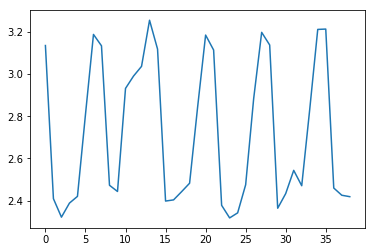

In [ ]:
plt.plot(testpreds[129])

In [ ]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [ ]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.724904   
air_0164b9927d20bcc3_2017-04-23              1.411191   
air_0241aa3964b7f861_2017-04-23              2.383072   
air_0328696196e46f18_2017-04-23              2.148211   
air_034a3d5b40d5b1b1_2017-04-23              3.522341   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.611982  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.100836  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.838145  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.569518  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.863594

In [ ]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [ ]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [ ]:
submission.to_csv("../submission/l4_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')